In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

import time

import os
import glob, time
import io
import random
import re

In [0]:
!rm UNSW_NB15_training-set.csv

In [45]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving UNSW_NB15_training-set.csv to UNSW_NB15_training-set.csv
User uploaded file "UNSW_NB15_training-set.csv" with length 32293018 bytes


In [46]:
training_set = pd.read_csv(io.StringIO(uploaded['UNSW_NB15_training-set.csv'].decode('utf-8')))
training_set.head(3)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0


#Training Data cleanup

In [0]:
dummy_cats = ['proto','service','state']
attack_dict = {k: v for v, k in enumerate(list(training_set.attack_cat.unique()))}

In [48]:
def getList(dict): 
    list = [] 
    for key in dict.keys(): 
        list.append(key) 
          
    return list

target_names = getList(attack_dict)
print(target_names)

['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode', 'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic']


In [0]:
training_set['attack_value'] = training_set['attack_cat'].map(attack_dict)

In [0]:
#training_set_dums = pd.get_dummies(training_set,columns=dummy_cats)
#training_set_dums.head(3)

In [51]:
training_set.attack_cat.value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

In [52]:
print('Total attacks:',training_set.label.sum(),'out of',training_set.shape[0])
print('Percent attacks:',round(training_set.label.sum()/training_set.shape[0],2)*100,'%')

Total attacks: 119341 out of 175341
Percent attacks: 68.0 %


In [53]:
#train, test = train_test_split(training_set_dums,test_size=0.2,random_state=15)
train, test = train_test_split(training_set,test_size=0.3,random_state=15)
train.shape

(122738, 46)

In [54]:
test.shape

(52603, 46)

In [0]:
train_X = train.drop(labels=['id','attack_cat','label','attack_value','proto','service','state'],axis=1)
train_y_binary = train.label
train_y_multi = train.attack_value



In [0]:
test_X = test.drop(labels=['id','attack_cat','label','attack_value','proto','service','state'],axis=1)
test_y_binary = test.label
test_y_multi = test.attack_value


#Validation Set

In [57]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving UNSW_NB15_testing-set.csv to UNSW_NB15_testing-set (1).csv
User uploaded file "UNSW_NB15_testing-set.csv" with length 15380800 bytes


In [58]:
val_set = pd.read_csv(io.StringIO(uploaded['UNSW_NB15_testing-set.csv'].decode('utf-8')))
val_set['attack_value'] = val_set['attack_cat'].map(attack_dict)
val_set.head(3)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,attack_value
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,0,180363632.0,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,0,881000000.0,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,0,854400000.0,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,Normal,0,0


In [0]:
val_X = val_set.drop(labels=['id','attack_cat','label','attack_value','proto','service','state'],axis=1)
val_y_binary = val_set.label
val_y_multi = val_set.attack_value

#PCA and SVM code

Results were not great

In [0]:
#pca = PCA(n_components=20)
start = time.time()
train_X_pca = pca.fit_transform(train_X)
end = time.time()
print(end-start)

2.306089162826538


In [0]:
clf = svm.SVC()

In [0]:
start = time.time()
clf.fit(train_X_pca, train_y_binary)
end = time.time()
print(end-start)

1457.5863127708435


In [0]:
start = time.time()
test_X_pca = pca.fit_transform(test_X)
end = time.time()
print(end-start)

0.5366420745849609


In [0]:
clf_binary_results = clf.predict(test_X_pca)
print(confusion_matrix(clf_binary_results,test_y_binary))
print(accuracy_score(test_y_binary, clf_binary_results))

[[ 4842  2861]
 [ 6418 20948]]
0.7354073398157918


In [0]:
start = time.time()
clf.fit(train_X_pca, train_y_multi)
end = time.time()
print(start-end)

In [0]:
clf_multi_results = clf.predict(test_X_pca)
print(confusion_matrix(clf_multi_results,test_y_multi))
print(accuracy_score(test_y_multi, clf_multi_results))

#Random Forest Binary Class Prediction

In [0]:
rf = RandomForestClassifier(n_estimators= 18 , oob_score=True, max_depth=15)

In [25]:
rf.fit(train_X,train_y_binary)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=18,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
rf_binary_results = rf.predict(test_X)
cm_binary_results = confusion_matrix(rf_binary_results,test_y_binary)
rf_testbinary_accuracy = accuracy_score(test_y_binary, rf_binary_results)
print(confusion_matrix(rf_binary_results,test_y_binary))
print(accuracy_score(test_y_binary, rf_binary_results))

[[15217   668]
 [ 1655 35063]]
0.9558390205881794


In [27]:
val_binary_results = rf.predict(val_X)
val_cm_binary_results = confusion_matrix(val_binary_results,val_y_binary)
rf_valset_binary_accuracy = accuracy_score(val_y_binary, val_binary_results)
print(confusion_matrix(val_binary_results,val_y_binary))
print(accuracy_score(val_y_binary, val_binary_results))

[[26437   616]
 [10563 44716]]
0.8642204732060438


In [28]:

binary_target_names = ['Normal','Attack']
print(classification_report(val_y_binary, val_binary_results, target_names=binary_target_names))

              precision    recall  f1-score   support

      Normal       0.98      0.71      0.83     37000
      Attack       0.81      0.99      0.89     45332

    accuracy                           0.86     82332
   macro avg       0.89      0.85      0.86     82332
weighted avg       0.88      0.86      0.86     82332



Text(0.5, 1.0, 'Random Forest Binary Class Prediction Confusion Matrix')

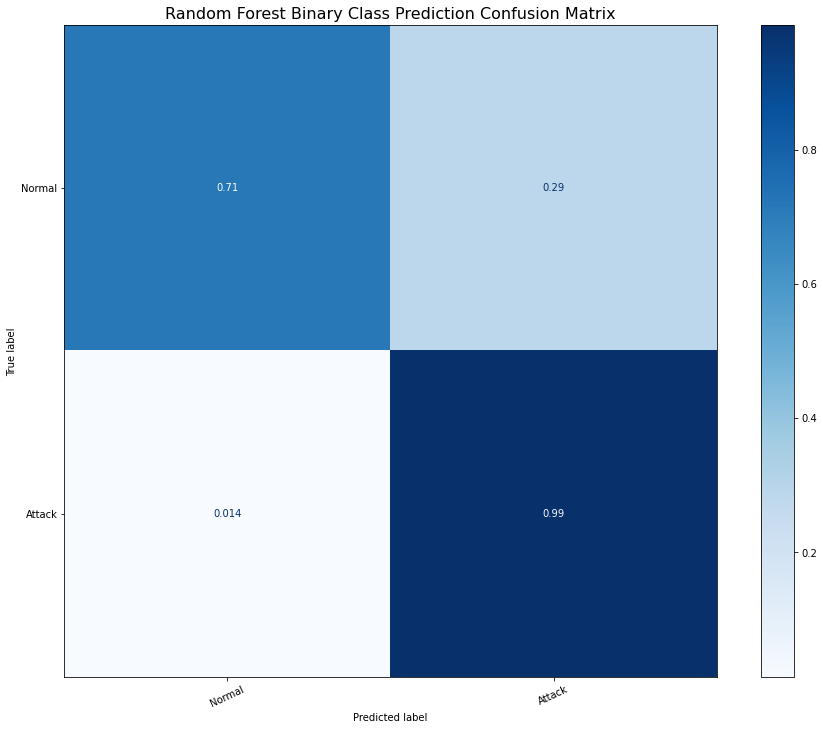

In [29]:
f, ax = plt.subplots(figsize=(16,12))
plot_confusion_matrix(rf, val_X,val_y_binary,display_labels=binary_target_names,cmap=plt.cm.Blues,normalize='true',xticks_rotation=25, ax=ax)
plt.title('Random Forest Binary Class Prediction Confusion Matrix', fontsize = 16)

#plt.savefig('rf_binary_cm.png',format='png')
#files.download('rf_binary_cm.png')

#Random Forest Multiclass Prediction

In [0]:
rf = RandomForestClassifier(n_estimators= 18 , oob_score=True, max_depth=15)

In [14]:
rf.fit(train_X,train_y_multi)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=18,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
rf_multi_results = rf.predict(test_X)
cm_results = confusion_matrix(rf_multi_results,test_y_multi)
rf_testset_accuracy = accuracy_score(test_y_multi, rf_multi_results)
print(confusion_matrix(rf_multi_results,test_y_multi))
print(accuracy_score(test_y_multi, rf_multi_results))

[[15403     3    99   705    10    20    82    12     0     2]
 [    0    55     5     0     0     2     3     0     0     0]
 [    8    11    74     4     0     0     2     0     0     0]
 [ 1277     6     3  4028    53    14   161    39     2    24]
 [   12     2     0    25   211     8    40    35     0     7]
 [   17     6     0     8     9  2356   160    18     0     2]
 [  149   446   421   511    52   723  9186  3194    22   216]
 [    6    31    36    31     2    55   342   305     1     7]
 [    0     0     0     0     0     0     0     0     3     1]
 [    0     0     0     1     5     0     3     0     0 11831]]
0.8260365378400472


In [31]:
val_multi_results = rf.predict(val_X)
val_cm_results = confusion_matrix(val_multi_results,val_y_multi)
rf_valset_accuracy = accuracy_score(val_y_multi, val_multi_results)
print(confusion_matrix(val_multi_results,val_y_multi))
print(accuracy_score(val_y_multi, val_multi_results))

[[27844     4    28   888    10    20    94    16     0     3]
 [    0    32    10    27     0    13    93    90     0     2]
 [  223    30    30    86     0    26   256   239     0     0]
 [ 7850   144   131  3724    54    67   570   319     3    83]
 [  108     6     3   145   227    20    67    54     1    19]
 [   38     1     1    12    20  2759   169    51     0     6]
 [  895   342   454  1136    62   580  9797  3037    34   532]
 [   40    10     6    16     2    11    57   269     0    29]
 [    0     0     0     0     0     0     1     0     6     1]
 [    2    14    14    28     3     0    28    14     0 18196]]
0.7637856483505806


In [73]:
#Code from https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
FP = val_cm_results.sum(axis=0) - np.diag(val_cm_results) 
FN = val_cm_results.sum(axis=1) - np.diag(val_cm_results)
TP = np.diag(val_cm_results)
TN = val_cm_results.sum() - (FP + FN + TP)
FPR = FP/(FP+TN)
FPR
#print('False Positive Rate:',round(FPR,2))

array([0.17138044, 0.00671419, 0.0079443 , 0.03369507, 0.00184863,
       0.00929675, 0.0203932 , 0.0466468 , 0.00046159, 0.01054144])

In [41]:
from sklearn.metrics import classification_report

print(classification_report(val_y_multi, val_multi_results, target_names=target_names))

                precision    recall  f1-score   support

        Normal       0.96      0.75      0.84     37000
      Backdoor       0.12      0.05      0.08       583
      Analysis       0.03      0.04      0.04       677
       Fuzzers       0.29      0.61      0.39      6062
     Shellcode       0.35      0.60      0.44       378
Reconnaissance       0.90      0.79      0.84      3496
      Exploits       0.58      0.88      0.70     11132
           DoS       0.61      0.07      0.12      4089
         Worms       0.75      0.14      0.23        44
       Generic       0.99      0.96      0.98     18871

      accuracy                           0.76     82332
     macro avg       0.56      0.49      0.47     82332
  weighted avg       0.83      0.76      0.77     82332



Text(0.5, 1.0, 'Random Forest Multiclass Prediction Confusion Matrix')

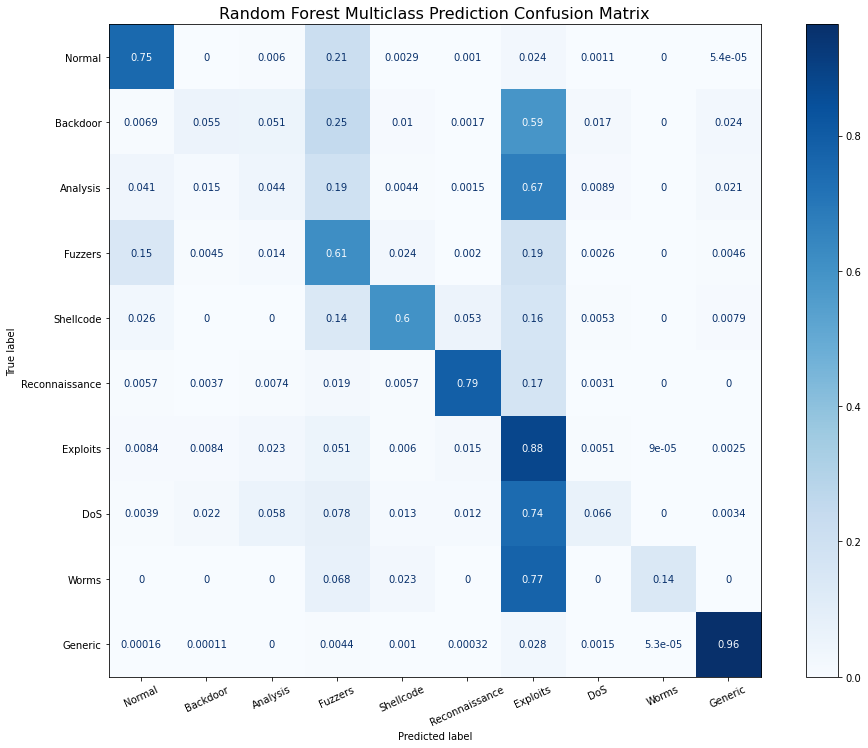

In [78]:
f, ax = plt.subplots(figsize=(16,12))
plot_confusion_matrix(rf, val_X,val_y_multi,display_labels=target_names,cmap=plt.cm.Blues,normalize='true',xticks_rotation=25, ax=ax)
plt.title('Random Forest Multiclass Prediction Confusion Matrix', fontsize = 16)

#plt.savefig('rf_multi_cm.png',format='png')
#files.download('rf_multi_cm.png')

In [0]:
param_grid = {
    'n_estimators': [3,6,12,18,24],
    'max_depth':[10,15,30,60,120]
}
gs = GridSearchCV(rf, param_grid, cv = 10)

In [0]:
gs.fit(train_X,train_y_multi)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=15,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=18, n_jobs=None,
                                              oob_score=True, random_state=None,
                                   

In [0]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=18,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

#Logistic Regression

Binary classes

In [0]:
lr = LogisticRegression()

In [31]:
lr.fit(train_X,train_y_binary)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
lr_binary_results = lr.predict(test_X)
lr_cm_binary_results = confusion_matrix(lr_binary_results,test_y_binary)
lr_testbinary_accuracy = accuracy_score(test_y_binary, lr_binary_results)
print(confusion_matrix(lr_binary_results,test_y_binary))
print(accuracy_score(test_y_binary, lr_binary_results))

[[10238  1127]
 [ 6634 34604]]
0.8524608862612398


In [33]:
val_lr_binary_results = lr.predict(val_X)
val_cm_lr_binary_results = confusion_matrix(val_lr_binary_results,val_y_binary)
lr_valset_binary_accuracy = accuracy_score(val_y_binary, val_lr_binary_results)
print(confusion_matrix(val_lr_binary_results,val_y_binary))
print(accuracy_score(val_y_binary, val_lr_binary_results))

[[14530  1715]
 [22470 43617]]
0.706250303648642


In [34]:
binary_target_names = ['Normal','Attack']
print(classification_report(val_y_binary, val_lr_binary_results, target_names=binary_target_names))

              precision    recall  f1-score   support

      Normal       0.89      0.39      0.55     37000
      Attack       0.66      0.96      0.78     45332

    accuracy                           0.71     82332
   macro avg       0.78      0.68      0.66     82332
weighted avg       0.77      0.71      0.68     82332



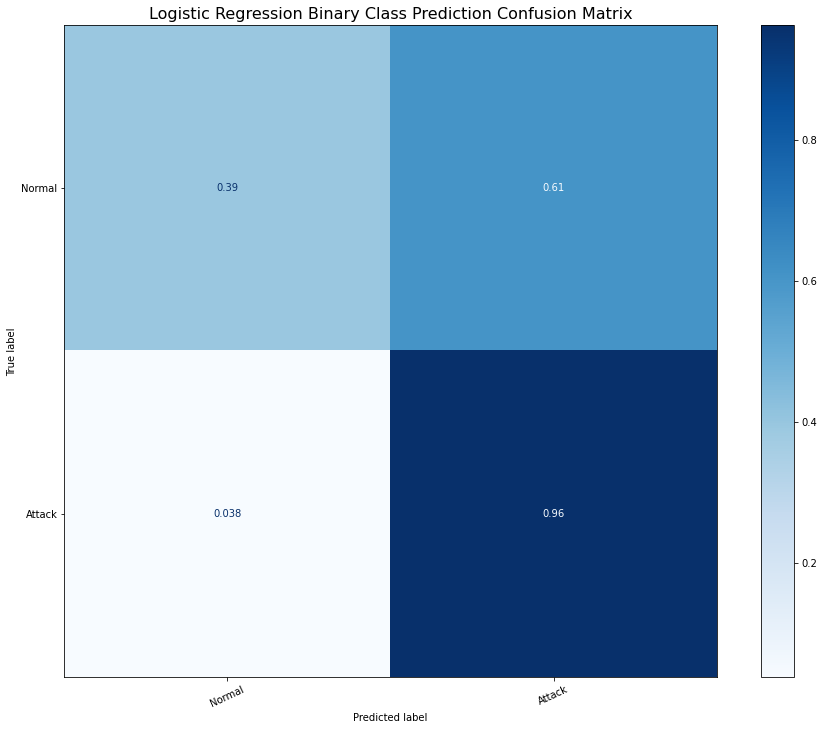

In [41]:
f, ax = plt.subplots(figsize=(16,12))
plot_confusion_matrix(lr, val_X,val_y_binary,display_labels=binary_target_names,cmap=plt.cm.Blues,normalize='true',xticks_rotation=25, ax=ax)
plt.title('Logistic Regression Binary Class Prediction Confusion Matrix', fontsize = 16)

#plt.savefig('lr_binary_cm.png',format='png')
#files.download('lr_binary_cm.png')

#ADABOOST

In [0]:
from sklearn.ensemble import AdaBoostClassifier

In [0]:
ada = AdaBoostClassifier(n_estimators=18)

In [62]:
ada.fit(train_X,train_y_binary)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=18, random_state=None)

In [63]:
ada_binary_results = ada.predict(test_X)
ada_cm_binary_results = confusion_matrix(ada_binary_results,test_y_binary)
ada_testbinary_accuracy = accuracy_score(test_y_binary, ada_binary_results)
print(confusion_matrix(ada_binary_results,test_y_binary))
print(accuracy_score(test_y_binary, ada_binary_results))

[[14348   964]
 [ 2524 34767]]
0.933691994753151


In [64]:
val_ada_binary_results = ada.predict(val_X)
val_cm_ada_binary_results = confusion_matrix(val_ada_binary_results,val_y_binary)
ada_valset_binary_accuracy = accuracy_score(val_y_binary, val_ada_binary_results)
print(confusion_matrix(val_ada_binary_results,val_y_binary))
print(accuracy_score(val_y_binary, val_ada_binary_results))

[[24505  1831]
 [12495 43501]]
0.8259971821406015


In [65]:
binary_target_names = ['Normal','Attack']
print(classification_report(val_y_binary, val_ada_binary_results, target_names=binary_target_names))

              precision    recall  f1-score   support

      Normal       0.93      0.66      0.77     37000
      Attack       0.78      0.96      0.86     45332

    accuracy                           0.83     82332
   macro avg       0.85      0.81      0.82     82332
weighted avg       0.85      0.83      0.82     82332



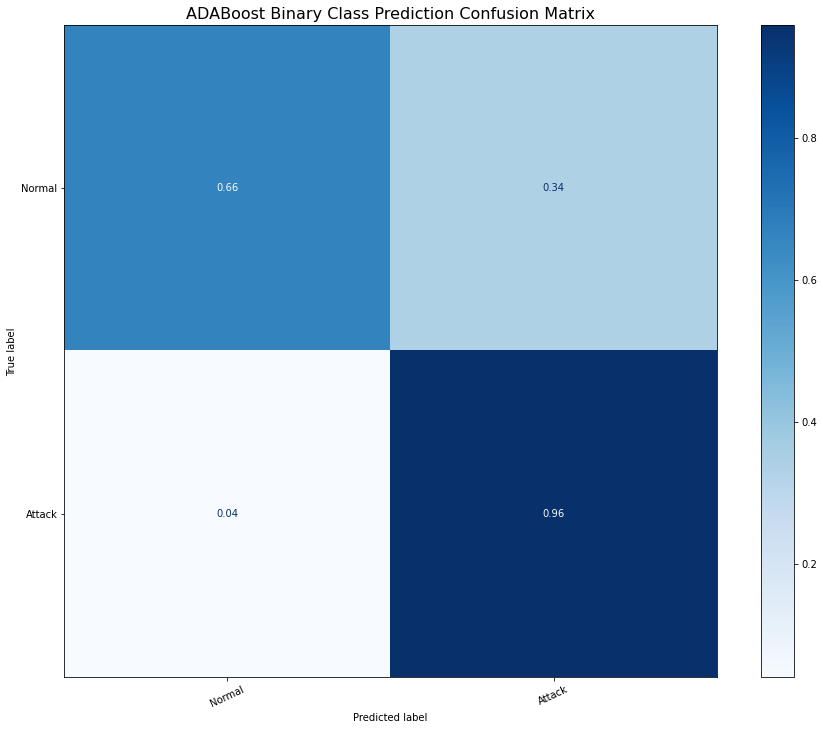

In [67]:
f, ax = plt.subplots(figsize=(16,12))
plot_confusion_matrix(ada, val_X,val_y_binary,display_labels=binary_target_names,cmap=plt.cm.Blues,normalize='true',xticks_rotation=25, ax=ax)
plt.title('ADABoost Binary Class Prediction Confusion Matrix', fontsize = 16)

#plt.savefig('ada_binary_cm.png',format='png')
#files.download('ada_binary_cm.png')

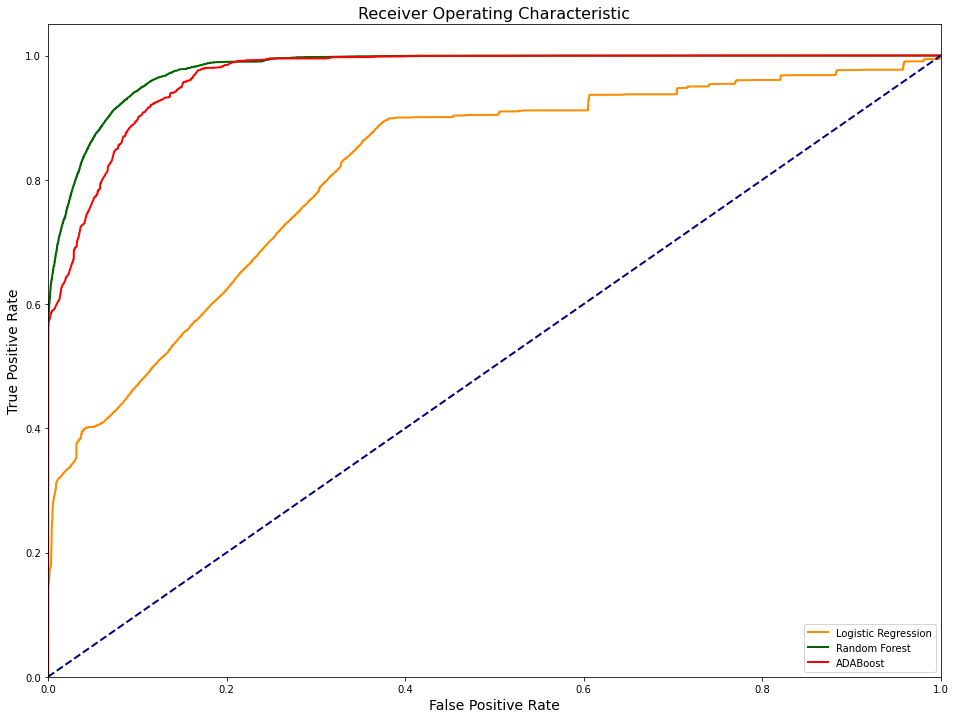

<Figure size 432x288 with 0 Axes>

In [39]:
lr_scores = lr.predict_proba(val_X)[:,0]
lr_fpr, lr_tpr, lr_thresholds = roc_curve(val_y_binary, lr_scores)

rf_scores = rf.predict_proba(val_X)[:,0]
rf_fpr, rf_tpr, rf_thresholds = roc_curve(val_y_binary, rf_scores)

ada_scores = ada.predict_proba(val_X)[:,0]
ada_fpr, ada_tpr, ada_thresholds = roc_curve(val_y_binary, ada_scores)

fig, ax = plt.subplots(figsize=(16,12))
lw = 2
ax.plot(lr_tpr, lr_fpr, color='darkorange',
         lw=lw, label='Logistic Regression')
ax.plot(rf_tpr, rf_fpr, color='darkgreen',
        lw = lw, label = 'Random Forest')
ax.plot(ada_tpr, ada_fpr, color='red',
        lw = lw, label = 'ADABoost')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('Receiver Operating Characteristic',fontsize=16)
plt.legend(loc="lower right")
plt.show()
#plt.savefig('unsw_roc.png',format='png')
#files.download('unsw_roc.png')